# Flow analysis

This notebook reproduces plots that appear in Figs 6 and 8 of the paper:
- Gilson M, Zamora-López G, Pallarés V, Adhikari MH, Senden M, Tauste Campo A, Mantini D, Corbetta M, Deco G, Insabato A (submitted) "Model-based whole-brain effective connectivity to study distributed cognition in health and disease", bioRxiv; https://doi.org/10.1101/531830.

The goal of this analysis is a network-oriented interpretation of the whole-brain dynamic model that is fitted to fMRI data (see the *MOU_EC_Estimation* notebook). By this we mean understanding how all the connections between regions of interest (effective connectivity) interplay to generate patterns of activity propagation. we use the amount of activity that propagates from a ROI to another to define interactions between ROIs that take into account indirect paths in the network. In particular, we use our network measures to compare the two conditions, rest (with eyes open) and movie viewing/listening.

It uses the library *NetDynFlow* to calculate the flow, which is presented in:
- Gilson M, Kouvaris NE, Deco G, Zamora-López G (2018) "Framework based on communicability and flow to analyze complex network dynamics", Phys Rev E 97: 052301; https://doi.org/10.1103/PhysRevE.97.052301.

See also for an application to resting-state fMRI data of the related network analysis using dynamic communicability:
- Gilson M, Kouvaris NE, Deco G, Mangin J-F, Poupon C, Lefranc S, Rivière D, Zamora-López G (2019) "Network analysis of whole-brain fMRI dynamics: A new framework based on dynamic communicability", *Neuroimage* 201, 116007  https://doi.org/10.1016/j.neuroimage.2019.116007.

In [6]:
# Toggle to True to create directory and store results there
save_outputs = True
if save_outputs:
    import os
    res_dir = 'flow/'
    if not os.path.exists(res_dir):
        os.mkdir(res_dir)

In [2]:
# Import dependencies
from __future__ import division
import numpy as np
import scipy.stats as stt

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
## Check whether NetDynFlow is installed, otherwise install using pip
try:
    import netdynflow
except:
    #! pip install git+https://github.com/mb-BCA/NetDynFlow.git@master
    ! pip install git+https://github.com/mb-BCA/NetDynFlow.git@version2
# Import NetDynFlow
import netdynflow as ndf

The following code loads the estimated parameters in the model, the Jacobian $J$ and the input covariance $\Sigma$ (a diagonal matrix), respectively $J$ and $Sigma$ in the code. The object *DynFlow* is the flow tensor, namely a cube indexed by time x ROI x ROI. It describes the interaction between the first indexed ROI to the second indexed ROI after the corresponding integration time. This cube is stored in a 5-dimensional array, indexed by subject x condition x time x ROI x ROI.

In [7]:
# Set the network properties
param_dir = 'model_param_movie/'
n_sub = 22 # number of subjects
n_run = 5  # first 2 rest + last 3 movie
N = 66     # number of ROIs

# Load the ROI labels
ROI_labels = np.load('ROI_labels.npy')

# Load the Jacobian and the noise covariance. Created in notebook 'MOU_EC_Estimation.ipybn'
J = np.load(param_dir + 'J_mod.npy')
Sigma = np.load(param_dir + 'Sigma_mod.npy')

# Create binary masks
mask_diag = np.eye(N,dtype=np.bool)
mask_offdiag = np.logical_not(mask_diag)

# Set the simulation properties
T = 40.  # duration
dt = 1.  # time step
vT = np.arange(0, T+dt*0.5, dt) # discrete simulation steps
nT = vT.size

# Calculate the dynamic flow, for every subject in all five sessions
flow = np.zeros([n_sub,n_run,nT,N,N]) # dynamic flow matrix
for i_sub in range(n_sub):
    for i_run in range(n_run):
        C_tmp = np.copy(J[i_sub,i_run,:,:])
        C_tmp[mask_diag] = 0
        tau_tmp = -1. / J[i_sub,i_run,:,:].diagonal().mean()
        flow[i_sub,i_run,:,:,:] = ndf.DynFlow(C_tmp, tau_tmp, Sigma[i_sub,i_run,:,:], tmax=T, timestep=dt)
        
if save_outputs:
    np.save(res_dir + 'flow.npy', flow)

## Global analysis of flow

Firstly, we evaluate the total flow, which is the sum of flow interactions between all pairs of ROIs. To do so we use the function `TotalEvolution()` on the flow tensor, for each subject and condition.
This quantifies the total activity propagation in the network, as a proxy for global communication. Importantly, this measure is time dependent, as the interactions measure the activity propagation following a perturbation whose amplitude at each node is described by $\Sigma$. The results show a higher level of interactions in the network for movie than for rest.

In the following plots, each curve corresponds to the average over all subjects and the bars indicate the standard error of the mean over the subjects.

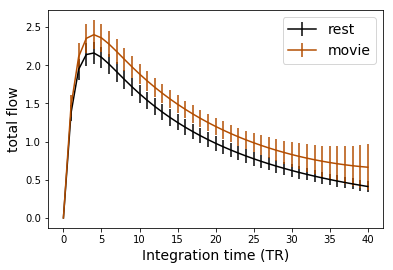

In [8]:
# Calculate total communicability, for each subject in all the five sessions
tot_tmp = np.zeros([n_sub,n_run,nT])
for i_sub in range(n_sub):
    for i_run in range(n_run):
        tot_tmp[i_sub,i_run,:] = ndf.TotalEvolution(flow[i_sub,i_run,:,:,:])

# Plot the results
plt.figure()
plt.errorbar(vT, tot_tmp[:,:2,:].mean(axis=(0,1)), yerr=tot_tmp[:,:2,:].std(axis=(0,1))/np.sqrt(n_sub), color='k')
plt.errorbar(vT, tot_tmp[:,2:,:].mean(axis=(0,1)), yerr=tot_tmp[:,2:,:].std(axis=(0,1))/np.sqrt(n_sub), color=[0.7,0.3,0])
plt.xlabel('Integration time (TR)', fontsize=14)
plt.ylabel('total flow', fontsize=14)
plt.legend(['rest','movie'], fontsize=14)
if save_outputs:
    plt.savefig(res_dir + 'total_flow.png', format='png')
    
plt.show()

Secondly, we use the function `Diversity()` to evaluate the flow diversity, which measures the heterogeneity between the flow interactions in the network. In practice, it is calculated as a coefficient of variation: the standard deviation divided by the mean across all matrix elements. The diversity can be interpreted as a degree of inhomonogeneity of the communication between ROIs.

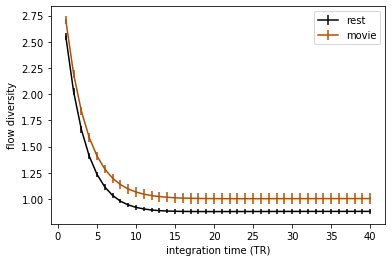

In [6]:
# Calculate the diversity, for every subject in all the five sessions
div_tmp = np.zeros([n_sub,n_run,nT])
for i_sub in range(n_sub):
    for i_run in range(n_run):
        div_tmp[i_sub,i_run,:] = ndf.Diversity(flow[i_sub,i_run,:,:,:])

# Visualise the results
plt.figure()
plt.errorbar(vT, div_tmp[:,:2,:].mean(axis=(0,1)), yerr=div_tmp[:,:2,:].std(axis=(0,1))/np.sqrt(n_sub), color='k')
plt.errorbar(vT, div_tmp[:,2:,:].mean(axis=(0,1)), yerr=div_tmp[:,2:,:].std(axis=(0,1))/np.sqrt(n_sub), color=[0.7,0.3,0])
plt.xlabel('integration time (TR)')
plt.ylabel('flow diversity')
plt.legend(['rest','movie'])
if save_outputs:
    plt.savefig(res_dir+'diversity_flow.png',format='png')

plt.show()

## ROI-based analysis of flow

Now we turn to the more refined scale of ROIs to examine the flow.

We also reorganize the list of ROIs to group them by anatomical regions, as done in the paper.

In [9]:
# Organize the ROIs into groups
# occipital ROIs
ind_occ = [3, 20, 12, 10, 6] # CUN, PCAL, LING, LOCC, FUS
# temporal ROIs
ind_tmp = [8, 14, 29, 32, 31] # IT, MT, ST, TT, TP
# parietal ROIs
ind_par = [7, 28, 30, 0, 24] # IP, SP, SMAR, BSTS, PCUN
# central ROIs
ind_cnt = [15, 23, 21] # PARC, PREC, PSTC
# frontal ROIs
ind_frnt = [5, 27, 26, 2, 11, 13, 17, 18, 19] # FP, SF, RMF, CMF, LOF, MOF, POPE, PORB, PTRI
# cingulate ROIs
ind_cing = [4, 16, 25, 1, 22, 9] # ENT, PARH, RAC, CAC, PC, ISTC

# rearranged list of ROIs for right hemisphere
ind_aff = np.array(ind_occ + ind_tmp + ind_par + ind_cnt + ind_frnt + ind_cing, dtype=np.int)

# get labels for homotopic regions
ROI_labels_sym = np.array(ROI_labels[:int(N/2)], dtype=np.str)
for i in range(int(N/2)):
    ROI_labels_sym[i] = ROI_labels_sym[i].replace(' ', '') # remove white space
    ROI_labels_sym[i] = ROI_labels_sym[i].replace('r', '') # remove first letter (left or right)    
ROI_labels_sym = ROI_labels_sym[ind_aff]

We calculate for the input and output flow for all each ROI, using function `NodeEvolution()` on the flow tensor.

In [10]:
# Calculate input and output flow for each node, in each subject for all 5 sessions
in_flow = np.zeros([n_sub,n_run,nT,N])
out_flow = np.zeros([n_sub,n_run,nT,N])
for i_sub in range(n_sub):
    for i_run in range(n_run):
        in_flow[i_sub,i_run,:,:], out_flow[i_sub,i_run,:,:] = ndf.NodeEvolution(flow[i_sub,i_run,:,:,:])

We first plot the input and output flow for the rest condition. The interpretation is as follows:
- strong input flow means that the ROI listens to the rest of the network (its activity is strongly affected by that of others);
- strong output flow means that the ROI broadcasts to the rest of the network (its activity strongly affects that of others).

The third plot can be used to classify ROI in listeners or broadcasters (or both).

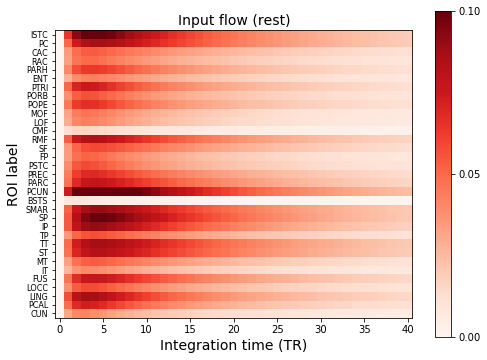

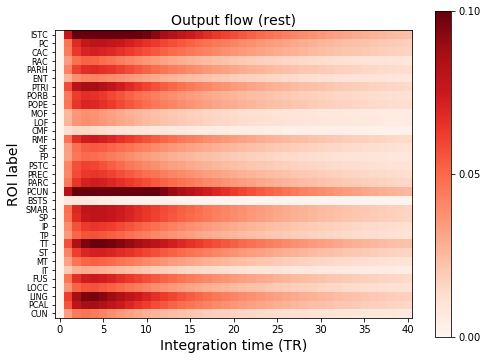

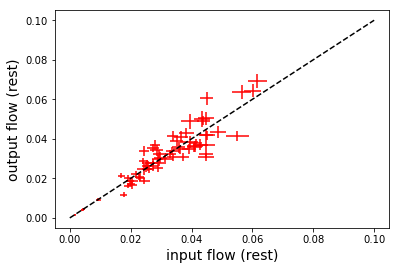

In [20]:
# Rest averaged over subjects and sessions
rest_in_flow  = in_flow[:,:2,:,:].mean(axis=(0,1))
rest_out_flow = out_flow[:,:2,:,:].mean(axis=(0,1))

# Group homotopic ROIs
sym_rest_in_flow  = rest_in_flow[:,:N//2] + rest_in_flow[:,N//2:][:,::-1]
sym_rest_out_flow = rest_out_flow[:,:N//2] + rest_out_flow[:,N//2:][:,::-1]

plt.figure(figsize=(8,6))
plt.imshow(sym_rest_in_flow[:,ind_aff].T, origin='lower', vmin=0, vmax=0.1, cmap='Reds')
plt.colorbar(ticks=[0,0.05,0.1])
#plt.xticks([0,nT],[0,int(T)])
plt.yticks(range(int(N/2)), ROI_labels_sym, fontsize=8)
plt.xlabel('Integration time (TR)', fontsize=14)
plt.ylabel('ROI label', fontsize=14)
plt.title('Input flow (rest)', fontsize=14)

plt.figure(figsize=(8,6))
plt.imshow(sym_rest_out_flow[:,ind_aff].T, origin='lower', vmin=0, vmax=0.1, cmap='Reds')
plt.colorbar(ticks=[0,0.05,0.1])
#plt.xticks([0,nT],[0,int(T)])
plt.yticks(range(int(N/2)), ROI_labels_sym, fontsize=8)
plt.xlabel('Integration time (TR)', fontsize=14)
plt.ylabel('ROI label', fontsize=14)
plt.title('Output flow (rest)', fontsize=14)

plt.figure()
plt.errorbar(in_flow[:,:2,5,:].mean(axis=(0,1)), out_flow[:,:2,5,:].mean(axis=(0,1)), \
            xerr = in_flow[:,:2,5,:].std(axis=(0,1)) / np.sqrt(2*n_sub), \
            yerr = out_flow[:,:2,5,:].std(axis=(0,1)) / np.sqrt(2*n_sub), c='r', ls='')
plt.plot([0,0.1], [0,0.1], '--k')
plt.xlabel('input flow (rest)', fontsize=14)
plt.ylabel('output flow (rest)', fontsize=14)

plt.show()

We then do the same plots for the movie condition.

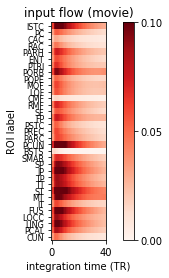

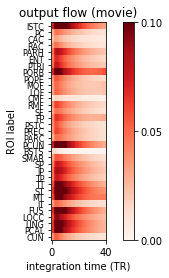

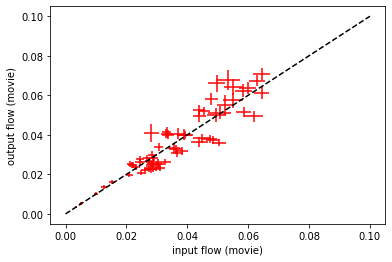

In [10]:
# Movie averaged over subjects and sessions
movie_in_flow = in_flow[:,2:,:,:].mean(axis=(0,1))
movie_out_flow = out_flow[:,2:,:,:].mean(axis=(0,1))

# Group homotopic ROIs
sym_movie_in_flow = movie_in_flow[:,:N//2] + movie_in_flow[:,N//2:][:,::-1]
sym_movie_out_flow = movie_out_flow[:,:N//2] + movie_out_flow[:,N//2:][:,::-1]

plt.figure()
plt.imshow(sym_movie_in_flow[:,ind_aff].T, origin='lower', vmin=0, vmax=0.1, aspect=5, cmap='Reds')
plt.colorbar(ticks=[0,0.05,0.1])
plt.xticks([0,nT],[0,int(T)])
plt.yticks(range(int(N/2)), ROI_labels_sym ,fontsize=8)
plt.xlabel('integration time (TR)')
plt.ylabel('ROI label')
plt.title('input flow (movie)')

plt.figure()
plt.imshow(sym_movie_out_flow[:,ind_aff].T, origin='lower', vmin=0, vmax=0.1, aspect=5, cmap='Reds')
plt.colorbar(ticks=[0,0.05,0.1])
plt.xticks([0,nT],[0,int(T)])
plt.yticks(range(int(N/2)), ROI_labels_sym ,fontsize=8)
plt.xlabel('integration time (TR)')
plt.ylabel('ROI label')
plt.title('output flow (movie)')

plt.figure()
plt.errorbar(in_flow[:,2:,5,:].mean(axis=(0,1)), out_flow[:,2:,5,:].mean(axis=(0,1)), \
            xerr=in_flow[:,2:,5,:].std(axis=(0,1))/np.sqrt(3*n_sub), \
            yerr=out_flow[:,2:,5,:].std(axis=(0,1))/np.sqrt(3*n_sub), c='r', ls='')
plt.plot([0,0.1], [0,0.1], '--k')
plt.xlabel('input flow (movie)')
plt.ylabel('output flow (movie)')

plt.show()

Finally, we plot the difference between the flow in the two conditions (average over the subjects), to see which ROIs change their listening/broadcasting roles from rest to movie.

The third plot shows that the main changes in movie compared to rest are ROIs increasing their broadcasting roles.

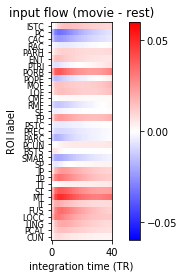

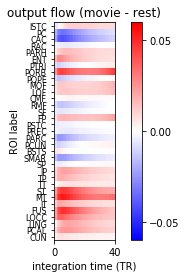

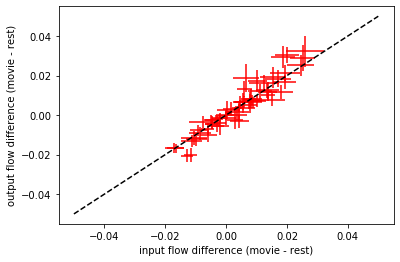

In [12]:
# difference movie minus rest averaged over subjects and sessions
diff_in_flow  = in_flow[:,2:,:,:].mean(axis=(0,1))  - in_flow[:,:2,:,:].mean(axis=(0,1))
diff_out_flow = out_flow[:,2:,:,:].mean(axis=(0,1)) - out_flow[:,:2,:,:].mean(axis=(0,1))

# group homotopic ROIs
sym_diff_in_flow  = diff_in_flow[:,:int(N/2)]  + diff_in_flow[:,int(N/2):][:,::-1]
sym_diff_out_flow = diff_out_flow[:,:int(N/2)] + diff_out_flow[:,int(N/2):][:,::-1]

plt.figure()
plt.imshow(sym_diff_in_flow[:,ind_aff].T, origin='lower', vmin=-0.06, vmax=0.06, aspect=4.5, cmap='bwr')
plt.colorbar(ticks=[-0.05,0,0.05])
plt.xticks([0,nT],[0,int(T)])
plt.yticks(range(int(N/2)), ROI_labels_sym, fontsize=8)
plt.xlabel('integration time (TR)')
plt.ylabel('ROI label')
plt.title('input flow (movie - rest)')
if save_outputs:
    plt.savefig(res_dir+'input_flow_diff.png',format='png')
    
plt.figure()
plt.imshow(sym_diff_out_flow[:,ind_aff].T, origin='lower', vmin=-0.06, vmax=0.06, aspect=4.5, cmap='bwr')
plt.colorbar(ticks=[-0.05,0,0.05])
plt.xticks([0,nT],[0,int(T)])
plt.yticks(range(int(N/2)), ROI_labels_sym, fontsize=8)
plt.xlabel('integration time (TR)')
plt.ylabel('ROI label')
plt.title('output flow (movie - rest)')
if save_outputs:
    plt.savefig(res_dir+'output_flow_diff.png',format='png')
    
plt.figure()
diff_in_flow_tmp = in_flow[:,2:,5,:].mean(axis=(1)) - in_flow[:,:2,5,:].mean(axis=(1))
diff_out_flow_tmp = out_flow[:,2:,5,:].mean(axis=(1)) - out_flow[:,:2,5,:].mean(axis=(1))
plt.errorbar(diff_in_flow_tmp.mean(0), diff_out_flow_tmp.mean(0), \
            xerr=diff_in_flow_tmp.std(0)/np.sqrt(n_sub), yerr=diff_out_flow_tmp.std(0)/np.sqrt(n_sub), c='r', ls='')
plt.plot([-0.05,0.05], [-0.05,0.05], '--k')
plt.xlabel('input flow difference (movie - rest)')
plt.ylabel('output flow difference (movie - rest)')

plt.show()